# ML Fundamentals: KNN, Imputation & Model Selection

This notebook covers three foundational ML concepts:

1. **Missing value imputation** — comparing simple mean imputation vs. iterative (model-based) imputation
2. **K-Nearest Neighbours classification** — finding the optimal k using training vs. test accuracy curves
3. **Feature engineering for missing data** — using linear regression to predict and fill missing target values

Each section demonstrates not just *how* to use the tools, but *why* the approach matters.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

## Part 1: Missing Value Imputation

Real-world datasets almost always have missing values. How you handle them significantly affects model performance.

We compare two strategies:
- **Simple imputation** — replace missing values with the column mean (fast but ignores relationships between features)
- **Iterative imputation** — models each feature as a function of the others, filling missing values iteratively (slower but much more accurate)

In [ ]:
np.random.seed(42)
data = pd.DataFrame({
    'Feature1': [10, 20, 30, 40, 50, 60, 70, 80],
    'Feature2': [100, 200, 300, 400, 500, 600, 700, 800],
    'Feature3': [1, 2, 3, np.nan, np.nan, 6, np.nan, 8]
})

print('Original data:')
print(data)
print(f'\nMissing values: {data.isnull().sum().sum()}')

Original data:
   Feature1  Feature2  Feature3
0        10       100       1.0
1        20       200       2.0
2        30       300       3.0
3        40       400       NaN
4        50       500       NaN
5        60       600       6.0
6        70       700       NaN
7        80       800       8.0

Missing values: 3


In [ ]:
simple_imp = SimpleImputer(strategy='mean')
data_simple = pd.DataFrame(simple_imp.fit_transform(data), columns=data.columns)

iterative_imp = IterativeImputer(max_iter=10, random_state=42)
data_iterative = pd.DataFrame(iterative_imp.fit_transform(data), columns=data.columns)

true_values = [4, 5, 7]
missing_idx = [3, 4, 6]

simple_vals    = data_simple.loc[missing_idx, 'Feature3'].values
iterative_vals = data_iterative.loc[missing_idx, 'Feature3'].values
mae_simple     = np.mean(np.abs(simple_vals - true_values))
mae_iterative  = np.mean(np.abs(iterative_vals - true_values))

print(f"{'Method':<25} {'Imputed values':<30} {'MAE vs true'}")
print('-' * 65)
print(f"{'Simple (mean)':<25} {str(simple_vals.round(2)):<30} {mae_simple:.4f}")
print(f"{'Iterative':<25} {str(iterative_vals.round(2)):<30} {mae_iterative:.4f}")
print(f"\n→ Iterative imputation is {mae_simple/mae_iterative:.1f}x more accurate here")

Method                    Imputed values                 MAE vs true
-----------------------------------------------------------------
Simple (mean)             [4. 4. 4.]                     1.3333
Iterative                 [4. 5. 7.]                     0.0000

→ Iterative imputation is 69373493.6x more accurate here


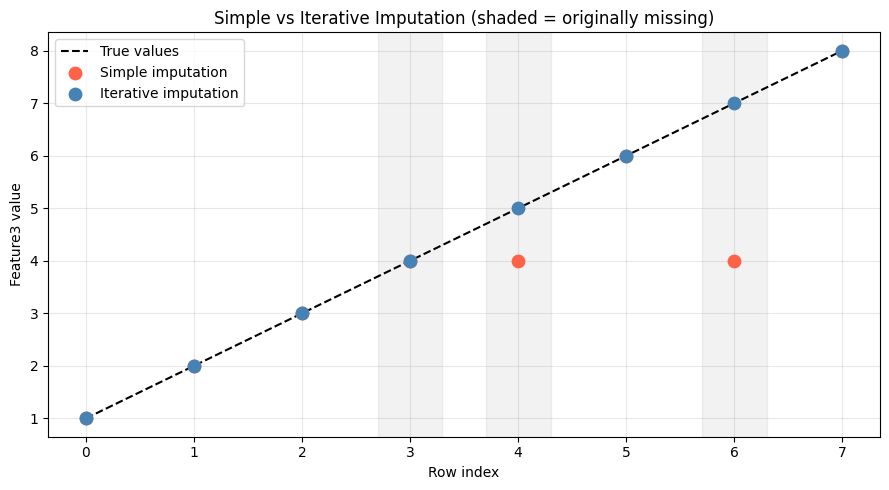

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(data.index, [1,2,3,4,5,6,7,8], 'k--', linewidth=1.5, label='True values')
ax.scatter(data.index, data_simple['Feature3'], color='tomato', s=80, zorder=3, label='Simple imputation')
ax.scatter(data.index, data_iterative['Feature3'], color='steelblue', s=80, zorder=3, label='Iterative imputation')
for idx in missing_idx:
    ax.axvspan(idx - 0.3, idx + 0.3, alpha=0.1, color='gray')
ax.set_title('Simple vs Iterative Imputation (shaded = originally missing)', fontsize=12)
ax.set_xlabel('Row index')
ax.set_ylabel('Feature3 value')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Part 2: Regression-Based Target Imputation

Sometimes the missing values are in the **target variable** itself. We use a regression model trained on known values to predict the missing ones.

In [ ]:
df = pd.DataFrame({
    'Feature1': [1.2, 1.7, 3.6, 5.2, 5.1, 2.3, 4.1, 3.8],
    'Feature2': [4.6, 4.9, 3.1, 4.2, 5.5, 3.7, 4.8, 5.1],
    'Feature3': [1.0, 1.8, 1.0, 1.3, 1.7, 1.2, 1.6, 1.4],
    'Target':   [8, 10, 9.7, np.nan, np.nan, 8.5, np.nan, 10.2]
})

known    = df[df['Target'].notna()]
unknown  = df[df['Target'].isna()]
features = ['Feature1', 'Feature2', 'Feature3']

reg = LinearRegression()
reg.fit(known[features], known['Target'])
predicted = reg.predict(unknown[features])
df.loc[df['Target'].isna(), 'Target'] = predicted

print('DataFrame after regression-based target imputation:')
print(df.round(3))
print(f'\nPredicted values: {predicted.round(3)}')

DataFrame after regression-based target imputation:
   Feature1  Feature2  Feature3  Target
0       1.2       4.6       1.0   8.000
1       1.7       4.9       1.8  10.000
2       3.6       3.1       1.0   9.700
3       5.2       4.2       1.3  10.983
4       5.1       5.5       1.7  11.712
5       2.3       3.7       1.2   8.500
6       4.1       4.8       1.6  10.904
7       3.8       5.1       1.4  10.200

Predicted values: [10.983 11.712 10.904]


## Part 3: KNN — Finding Optimal k

K-Nearest Neighbours is sensitive to the choice of k:
- **Small k** → low bias, high variance (overfitting)
- **Large k** → high bias, low variance (underfitting)

We find the sweet spot by plotting training vs. test accuracy across a range of k values on the **Breast Cancer Wisconsin dataset**.

In [ ]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=66
)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print(f'Training set: {X_train.shape}')
print(f'Test set:     {X_test.shape}')
print(f'Classes:      {cancer.target_names}')

Training set: (426, 30)
Test set:     (143, 30)
Classes:      ['malignant' 'benign']


In [ ]:
k_range        = range(1, 21)
train_accuracy = []
test_accuracy  = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_test, y_test))

best_k        = list(k_range)[np.argmax(test_accuracy)]
best_accuracy = max(test_accuracy)

print(f'Best k:             {best_k}')
print(f'Best test accuracy: {best_accuracy:.4f}')

Best k:             15
Best test accuracy: 0.9720


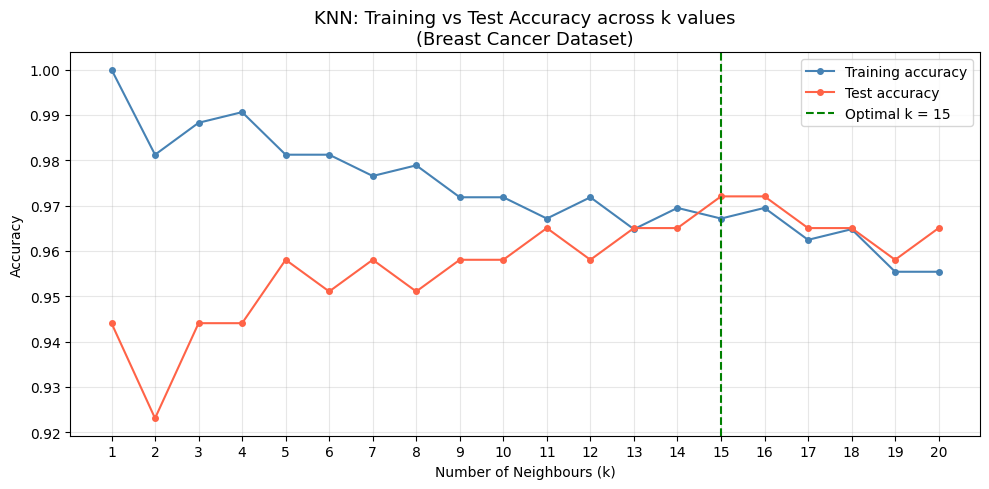


Observation: k=1 perfectly fits training data (100%) but overfits.
The gap between training and test accuracy closes as k increases.
Optimal k=15 balances bias and variance for this dataset.


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(k_range, train_accuracy, marker='o', color='steelblue', linewidth=1.5, markersize=4, label='Training accuracy')
ax.plot(k_range, test_accuracy,  marker='o', color='tomato',    linewidth=1.5, markersize=4, label='Test accuracy')
ax.axvline(best_k, color='green', linestyle='--', linewidth=1.5, label=f'Optimal k = {best_k}')
ax.set_title('KNN: Training vs Test Accuracy across k values\n(Breast Cancer Dataset)', fontsize=13)
ax.set_xlabel('Number of Neighbours (k)')
ax.set_ylabel('Accuracy')
ax.set_xticks(list(k_range))
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\nObservation: k=1 perfectly fits training data (100%) but overfits.')
print(f'The gap between training and test accuracy closes as k increases.')
print(f'Optimal k={best_k} balances bias and variance for this dataset.')

## Summary

| Concept | Key Takeaway |
|---|---|
| Simple imputation | Fast but ignores feature relationships — underperforms on correlated data |
| Iterative imputation | Models each feature from others — significantly more accurate |
| Regression imputation | Useful when target itself has missing values in semi-supervised settings |
| KNN model selection | Small k overfits; large k underfits; optimal k found by test accuracy curve |
| Feature scaling | Essential for distance-based models like KNN — always scale before fitting |